In [1]:
# Importing the recquired libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())

1.1.0
3.7.3


In [2]:
top_1000_words = pd.read_csv('D:/Machine Learning/Pytorch/PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/\
03-CNN-Convolutional-Neural-Networks/top_1000.txt', delimiter = '\t', header = None)

words = []

for i in range(len(top_1000_words)):
    for j in range(0, 10):
        words.append(top_1000_words[0][i])
        
import random
random.seed(101)
random.shuffle(words)
n = len(words)

print(n)
print(words[0:15])

10000
['best', 'place', 'grow', 'answer', 'select', 'consonant', 'most', 'wave', 'red', 'hair', 'leave', 'love', 'street', 'finger', 'better']


In [3]:
# Splitting into training and test sets:

#train_set = words[0:800] # bajamos un orden de magnitud el training set
#test_set = words[800:1000] # bajamos un orden de magnitud el test 
#len_train = len(train_set)
#len_test = len(test_set)

In [10]:
train_set = ['urjc', 'gavab'] * 400
#train_set = words[0:32]*128
#print(train_set[0:32])
#import random
#random.seed(101)
#random.shuffle(train_set)
len_train = len(train_set)

#print(train_set[0:15])

In [5]:
# Function to convert letters (and therefore words) into PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(letter_to_vector('SOS_token'))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [6]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        output = input.view(1,1,-1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [7]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = input.view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [8]:
# Instantiate the model, define loss and optimization functions:

torch.manual_seed(101)

input_size = 28
hidden_size = 256
output_size = 28

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr=0.01)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr=0.01)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [24]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Setting the sliding window parameters:
max_length = 20
epochs = 25
train_losses = []
test_losses = []

for i in range(epochs):
    
    for j in range(len_train): # we chose individual words/images as batches:
        
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        input_word = list(train_set[j])
        input_word_length = len(input_word) # number of letters
        
        encoder_hidden = Encoder_model.initHidden()
        
        
        for l in range(input_word_length):
            
            encoder_input = letter_to_vector(input_word[l])
            encoder_output, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
            
        decoder_input = letter_to_vector('SOS_token')
        decoder_hidden = encoder_hidden
        
        
        for d in range(input_word_length):
            
            decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
            #decoder_input = letter_to_vector(input_word[d])
            
            one_hot_decoder_output = torch.zeros(1, 1, output_size)
            one_hot_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
            decoder_input = one_hot_decoder_output
            
            if torch.equal(one_hot_decoder_output, letter_to_vector('EOS_token'))==True:
                break
            
            if d == 0:
                
                output_word = decoder_output 
                one_hot_input_word = letter_to_vector(input_word[d]).type(torch.LongTensor)
                index = torch.argmax(one_hot_input_word.view(output_size))
                ground_word = torch.tensor([index], dtype = torch.long)
                
            else:
                
                output_word = torch.cat((output_word, decoder_output), dim = 0) # we concatenate the remaining output letters
                one_hot_input_word = torch.cat((one_hot_input_word,
                                       letter_to_vector(input_word[d]).type(torch.LongTensor)), dim = 0)

        
        one_hot_input_word = one_hot_input_word.view(-1, output_size)
        output_word = output_word.view(-1, output_size) 
        ground_word = torch.argmax(one_hot_input_word, dim = 1)
        loss = criterion(output_word, ground_word)
        
        loss.backward()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        
    train_losses.append(loss)
    print(i)
print(train_losses)
print(f'Duration: {(time.time() - start_time)/60} minutes')



KeyboardInterrupt: 

In [26]:
torch.save(Encoder_model.state_dict(), 'Encoder_model.pt')
torch.save(Decoder_model.state_dict(), 'Decoder_model.pt')

Text(0.5, 1.0, 'Losses per epoch E-D only-10 words')

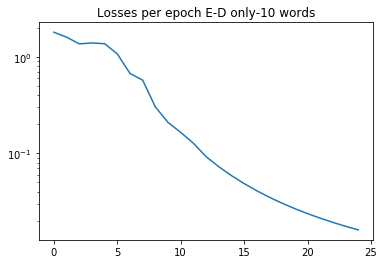

In [26]:
# Plotting loss function:
plt.yscale("log")
plt.plot(train_losses)
plt.title('Losses per epoch E-D only-10 words')
#plt.savefig('E-D_only_800sample.png')

In [64]:
input_word_test = 'spent'

with torch.no_grad():
        
    input_word_test = list(input_word_test)
    input_word_test_length = len(input_word_test) # number of letters

    encoder_hidden_test = Encoder_model.initHidden()


    for l in range(input_word_test_length):

        encoder_input_test = letter_to_vector(input_word_test[l])
        _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test)


    decoder_input_test = letter_to_vector('SOS_token')
    decoder_hidden_test = encoder_hidden_test


    for d in range(input_word_test_length):

        decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test)
        #decoder_input = letter_to_vector(input_word[d])

        one_hot_decoder_output_test = torch.zeros(1, 1, output_size)
        one_hot_decoder_output_test[0][0][torch.argmax(decoder_output_test)] = 1.
        decoder_input_test = one_hot_decoder_output_test

        if torch.equal(one_hot_decoder_output_test, letter_to_vector('EOS_token'))==True:
            break

        if d == 0:

            output_word_test = decoder_output_test
            one_hot_input_word_test = letter_to_vector(input_word_test[d]).type(torch.LongTensor)
            index_test = torch.argmax(one_hot_input_word_test.view(output_size))
            ground_word_test = torch.tensor([index_test], dtype = torch.long)

        else:

            output_word_test = torch.cat((output_word_test, decoder_output_test), dim = 0) 
            one_hot_input_word_test = torch.cat((one_hot_input_word_test,
                                   letter_to_vector(input_word_test[d]).type(torch.LongTensor)), dim = 0)


    one_hot_input_word_test = one_hot_input_word_test.view(-1, output_size)
    output_word_test = output_word_test.view(-1, output_size) 
    ground_word_test = torch.argmax(one_hot_input_word_test, dim = 1)
    
    
model_word = []

indices = torch.argmax(output_word_test, dim = 1)

for i in range(indices.numel()):
    model_word.append(letters[indices[i]])

model_word = ''.join(model_word)    
print(model_word)


sesee
